In [1]:
import tensorflow.keras.backend as K
import tensorflow as tf
import cv2 as cv
import numpy as np
import utils.model_helper as mh
import utils.data_utils as du
import utils.metrics as M
import os
import matplotlib.pyplot as plt

2023-06-08 01:43:20.211306: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-08 01:43:20.244172: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-08 01:43:20.244806: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-08 01:43:21.039019: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tf.__version__

'2.12.0'

In [3]:
DATASET_PATH = '/home/irizqy/ml_ws/bangkit-ws/data/bizz.it-sim_dataset'

In [4]:
train_pairs, train_labels, test_pairs, test_labels = du.make_train_test_pairs(DATASET_PATH, .2)

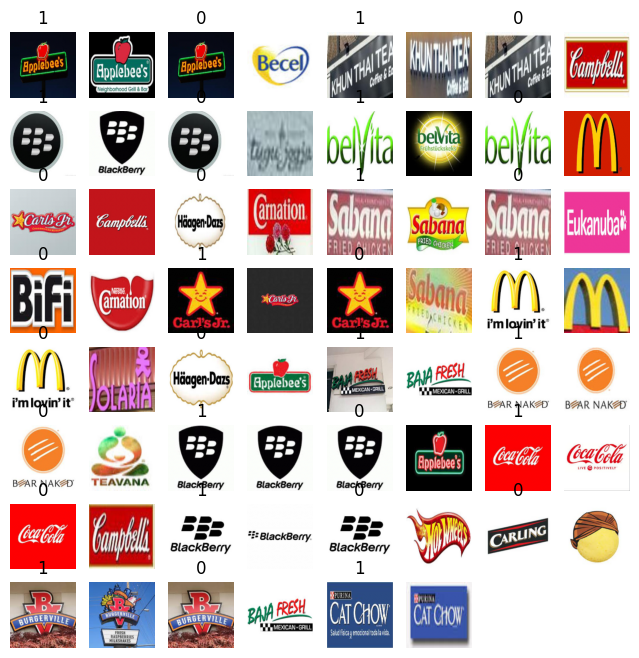

In [5]:
w = 20
h = 15
fig = plt.figure(figsize=(8, 8))
columns = 8
rows = 8
for index, i in enumerate(range(1, (columns*rows +1)//2)):
    img = train_pairs[index][0]
    fig.add_subplot(rows, columns, 2*i - 1) 
    plt.title(train_labels[index])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    img = train_pairs[index][1]
    fig.add_subplot(rows, columns, 2*i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')


In [6]:
IMG_SHAPE = (150, 150, 3)
BATCH_SIZE = 8
EPOCHS = 100

In [7]:
class SiameseModel:

    def __init__(self, input_shape, embedding_dim=224):
        self.input_shape = input_shape
        self.embedding_dim = embedding_dim

    def _build(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=self.input_shape),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Dropout(.1),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Dropout(.1),

            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(self.embedding_dim)
        ])

        return model

In [8]:
sm = SiameseModel(IMG_SHAPE)

featureExtractor = sm._build()

# base_cnn =  tf.keras.applications.resnet.ResNet50(
#     weights='imagenet', input_shape=IMG_SHAPE, include_top=False
# )

# cnn_model = base_cnn.get_layer('conv5_block3_2_conv')

# flatten = tf.keras.layers.Flatten()(cnn_model.output)
# # dense_1 = tf.keras.layers.Dense(units=256, activation='relu')(flatten)
# dense_2 = tf.keras.layers.Dense(units=128, activation='relu')(flatten)

# featureExtractor = tf.keras.Model(base_cnn.input, dense_2)

# for layer in featureExtractor.layers[:-15]:
#     layer.trainable = False

featureExtractor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 74, 74, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 36, 36, 64)        0

2023-06-08 01:43:26.467717: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 01:43:26.468234: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [9]:
# configure the siamese network
print("[INFO] building siamese network...")
imgA = tf.keras.layers.Input(shape=IMG_SHAPE)
imgB = tf.keras.layers.Input(shape=IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

[INFO] building siamese network...


In [11]:
# finally, construct the siamese network
distance = tf.keras.layers.Lambda(M.euclidean_distance)([featsA, featsB])
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(distance)
model = tf.keras.Model(inputs=[imgA, imgB], outputs=outputs)

In [12]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224)          53280       ['input_1[0][0]',                
                                                                  'input_2[0][0]']          

In [ ]:
tf.keras.backend.clear_session()
# compile the model
print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(),
	metrics=["accuracy"])
# train the model
print("[INFO] training model...")
history = model.fit(
	[train_pairs[:, 0], train_pairs[:, 1]], train_labels[:],
	validation_data=([test_pairs[:, 0], test_pairs[:, 1]], test_labels[:]),
	batch_size=BATCH_SIZE, 
	epochs=EPOCHS)

In [ ]:
def plot_training(H):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")

In [ ]:
plot_training(history)

In [ ]:
model.save('/home/irizqy/ml_ws/bangkit-ws/src/logo-detector/im_similar')

In [ ]:
model = tf.keras.models.load_model('/home/irizqy/ml_ws/bangkit-ws/src/logo-detector/im_similar')

In [ ]:
from PIL import Image, ImageOps

preds = []

test_data = os.listdir('/home/irizqy/ml_ws/bangkit-ws/data/bizz.it-sim_dataset')

path_im1_1 = '/home/irizqy/ml_ws/bangkit-ws/src/logo-detector/cropped-logo0.jpg'
path_im1_2 = '/home/irizqy/Downloads/yamie-panda.jpeg'

path_im2_1 = '/home/irizqy/ml_ws/bangkit-ws/data/bizz.it-sim_dataset/sabana_12.jpg'
path_im2_2 = '/home/irizqy/Downloads/Screenshot from 2023-06-08 00-18-31.png'

im1 = mh.adjust_im(path_im1_2, (150, 150))
im2 = mh.adjust_im(path_im2_2, (150, 150))

model.predict((im1, im2))[0][0]

# for file in test_data:
    # im2 = mh.adjust_im(path_im2_2, (150, 150))
#     pred = model.predict((im1, image2))[0][0]
#     preds.append(pred)

# preds = np.asarray(preds)

In [ ]:
max_idx = np.argmax(preds)
print(max_idx, preds[max_idx])

In [ ]:
test_data[max_idx]